In [9]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models
import matplotlib.pyplot as plt

# Definisci i percorsi dei dataset
train_dir = "/home/lorenzo/Documenti/Machine Learning/Computer Vision/Final Project/data/Raod_Crack_256-20241015T162221Z-001/Raod_Crack_256/Training"
val_dir   = "/home/lorenzo/Documenti/Machine Learning/Computer Vision/Final Project/data/Raod_Crack_256-20241015T162221Z-001/Raod_Crack_256/Validation"
test_dir  = "/home/lorenzo/Documenti/Machine Learning/Computer Vision/Final Project/data/Raod_Crack_256-20241015T162221Z-001/Raod_Crack_256/Testing"

# Parametri del modello
BATCH_SIZE = 64
IMG_SIZE = (256, 256)
EPOCHS = 1
LEARNING_RATE = 0.1
NUM_CLASSES = 3

# Definizione delle trasformazioni per il preprocessing delle immagini
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # Normalizzazione standard
    ]),
    'val': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(IMG_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

In [10]:
# Carica il dataset con ImageFolder e DataLoader
train_dataset = datasets.ImageFolder(train_dir, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(val_dir, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(test_dir, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

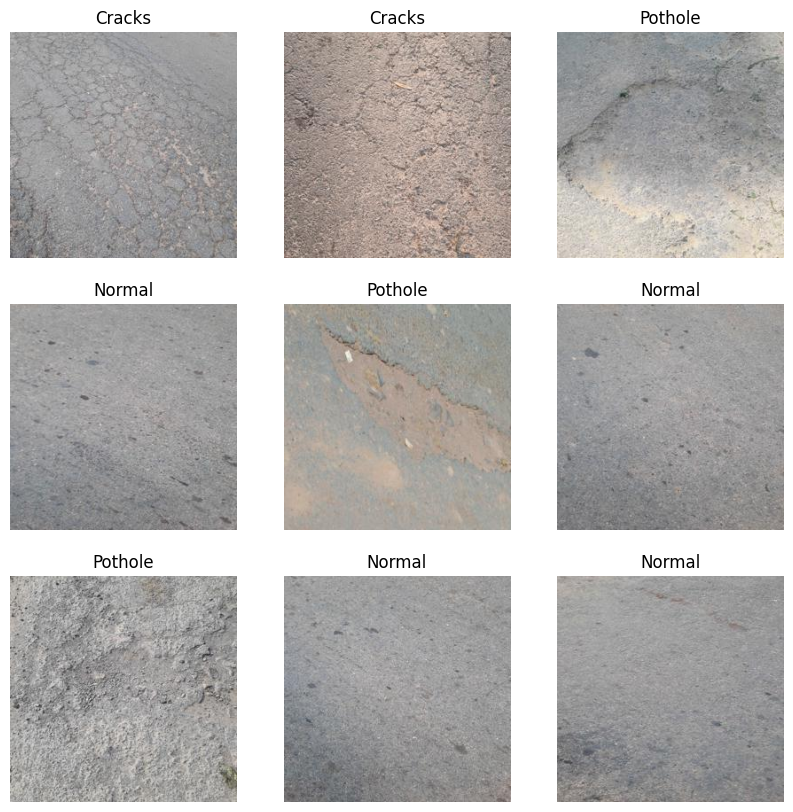

In [11]:
# Visualizza alcune immagini del dataset
class_names = train_dataset.classes

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = torch.clamp(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

# Visualizza alcune immagini
inputs, classes = next(iter(train_loader))
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    imshow(inputs[i], title=class_names[classes[i]])

In [12]:
# Definizione del modello
class RoadCrackCNN(nn.Module):
    def __init__(self, num_classes=NUM_CLASSES):
        super(RoadCrackCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(128 * 32 * 32, 128),
            nn.ReLU(inplace=True),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

# Istanzia il modello
model = RoadCrackCNN(NUM_CLASSES)

# Definizione della funzione di perdita e dell'ottimizzatore
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [13]:
from tqdm import tqdm  # Barra di avanzamento

# Funzione per il training del modello con barra di avanzamento
def train_model(model, criterion, optimizer, num_epochs=EPOCHS):
    model.train()  # Imposta il modello in modalità training
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0
        
        # Aggiungi la barra di avanzamento per i batch
        with tqdm(train_loader, unit="batch") as tepoch:
            tepoch.set_description(f"Epoch {epoch + 1}/{num_epochs}")
            
            for inputs, labels in tepoch:
                optimizer.zero_grad()
                
                # Forward pass
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass
                loss.backward()
                optimizer.step()
                
                # Aggiorna i parametri per il calcolo della loss e accuracy
                running_loss += loss.item() * inputs.size(0)
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Aggiorna la barra di avanzamento con la loss e l'accuratezza
                tepoch.set_postfix(loss=loss.item(), accuracy=100. * correct / total)

        # Calcolo della loss e accuracy per ogni epoca
        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_acc:.4f}")

# Funzione per la validazione del modello
def evaluate_model(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [14]:
# Training del modello
train_model(model, criterion, optimizer)

# Valutazione del modello sui dati di test
test_acc = evaluate_model(model, test_loader)
print(f"Test Accuracy: {test_acc:.4f}")

Epoch 1/1: 100%|██████████| 70/70 [05:03<00:00,  4.34s/batch, accuracy=33.6, loss=1.87]  


Epoch 1/1, Loss: 59543.9637, Accuracy: 0.3357
Test Accuracy: 0.3495
